In [85]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Visualize
import seaborn as sns
import matplotlib.pyplot as plt

# Metrics
from sklearn.metrics import multilabel_confusion_matrix

# Myutils
from modules.get_data_function import get_dataset

In [86]:
# =========== Declare Variable ==============
STRATEGY = tf.distribute.get_strategy()    
BATCH_SIZE = 16
IMG_SIZE = 224
SEED = 42
input_path = "dataset/ChestXray NIH"


# =========================== Functions =====================================
def main():
    test_filenames = tf.io.gfile.glob(f'{input_path}/data/224x224/test/*.tfrec')
    test_dataset = get_dataset(test_filenames)
    
    tf.keras.backend.clear_session()
    model = tf.keras.models.load_model(f"/home/jovyan/ChestXray-14/results/models/Resnet50_epochs-20.h5")
    preds = model.predict(test_dataset)
    print(preds)
    
    return test_dataset, preds


# ============ Run Main Program =============
if tf.test.gpu_device_name():
    """
    Check if a GPU is none it's will terminate programs.
    """
    test_dataset, preds = main()
else:
    print("\n===== Please, install GPU =====")
# ===========================================

2022-07-20 08:49:25.681508: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 31733 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:17:00.0, compute capability: 8.0


700/700 [==============================] - 20s 26ms/step
[[6.5012467e-01 4.8834119e-02 2.4356164e-02 ... 4.1446771e-02
  4.8786987e-02 2.1746310e-03]
 [3.2958460e-01 1.8576491e-01 1.3243873e-01 ... 4.6839975e-02
  5.4189105e-02 9.3676953e-04]
 [2.2559632e-01 2.2842360e-01 2.0745215e-01 ... 2.0029103e-02
  2.9370606e-02 1.1589535e-04]
 ...
 [7.7393824e-01 2.8737141e-02 5.9537697e-03 ... 3.3177078e-02
  2.0062646e-02 2.9612530e-03]
 [2.5232893e-01 1.9173194e-01 2.0306845e-01 ... 2.2736503e-02
  3.1068336e-02 4.8490037e-04]
 [2.2361951e-01 6.6016868e-02 1.6290361e-01 ... 3.5048943e-02
  5.4418180e-02 1.1108981e-04]]


In [ ]:
# def get_label_from_test_dataset(dataset):
#     tmp = []
#     for data in dataset:
#         labels = data[1]
#         for label in labels:
#             tmp.append(label.numpy())
#     return tmp

In [95]:

def get_label_from_test_dataset(dataset):
    for data in dataset:
        labels = data[1]
        for label in labels:
            yield label.numpy().tolist()
            
test_dataset_all = get_label_from_test_dataset(test_dataset)

y_true = np.array(list(test_dataset_all))
y_true[:5]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [88]:
len(list_test_dataset_all)

11200

In [89]:
len(preds)

11200

In [90]:
y_preds = (preds > 0.5).astype("int8")
y_preds

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [97]:
y_true

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:

def my_multi_label_cunfusion_metrics(y_trues, y_preds):
    tmp = tf.zeros(shape=(15,15),
                   dtype="int32")
    for y_true, y_pred in zip(y_trues, y_preds):
        tmp = tmp + tf.math.confusion_matrix(y_true, y_pred, num_classes=15)
        
    return tmp


confusion_metrics = my_multi_label_cunfusion_metrics(y_true, y_preds)

<AxesSubplot:>

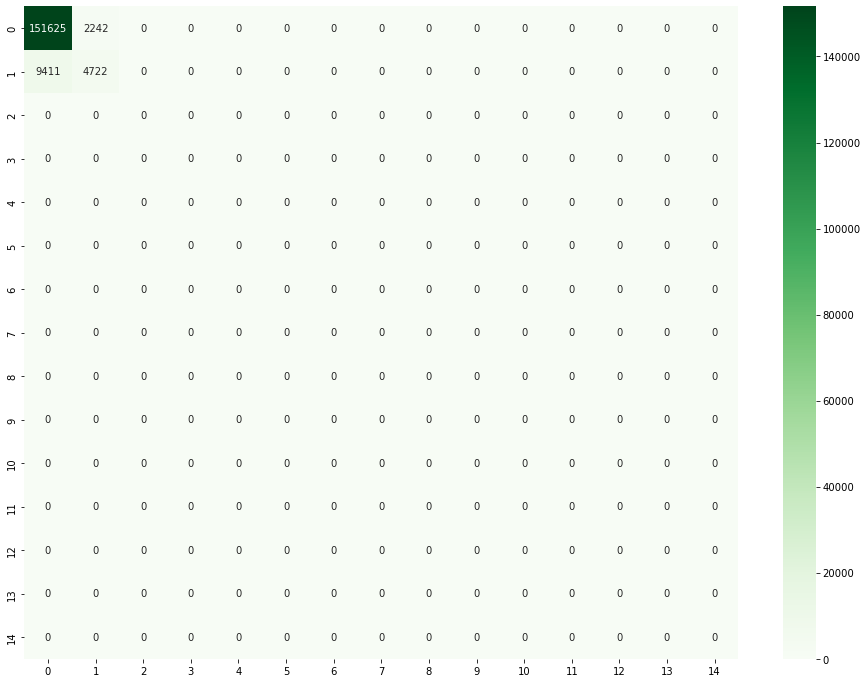

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))
sns.heatmap(confusion_metrics,
            cmap="Greens",
            annot=True,
            label=True,
            fmt=".10g")

In [ ]:
col_names = ['No Finding', 'Atelectasis', 'Consolidation', 'Infiltration',
   'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion',
   'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass',
   'Hernia']